In [4]:
import pandas as pd
import seaborn as sns
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib.collections
from typing import *
import math
import json
from utils import dref_dataframe, dref_dataframe_multi
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

sns.set_style("whitegrid")
#sns.set_context("poster", font_scale=0.75)
sns.set_context("poster", font_scale=1.3)
sns.set_palette("colorblind6")

def set_plt_font_size(size: int = 16):
    return
    #plt.rc('font', size=size)
    #plt.rc('axes', titlesize=size)
    #plt.rc('axes', labelsize=size)
    #plt.rc('xtick', labelsize=size)
    #plt.rc('ytick', labelsize=size)
    #plt.rc('legend', fontsize=size)
    #plt.rc('figure', titlesize=size)
    #sns.set_theme(font_scale=2)

def calc_stats(data: pd.DataFrame, cores: list[int], data_col: str) -> pd.DataFrame:
    rows = []
    for c in cores:
        core_data = data.loc[data["Cores"] == c]
        for d in ["Baseline", "virtio-balloon", "virtio-balloon-huge", "virtio-mem", "virtio-mem+VFIO", "HyperAlloc", "HyperAlloc+VFIO"]:
            driver_data = core_data.loc[core_data["Driver"] == d]
            std = driver_data[data_col].std()
            mean = driver_data[data_col].mean()
            rows.append({"Cores":c, "Driver":d, "Mean":mean, "Std":std})

    return pd.DataFrame(rows)

def render_plt(fig, name: str, path: Path = Path("stream")):
    fig.savefig(path / f"{name}.pdf", bbox_inches="tight", dpi=100)

In [33]:
DRIVER_MAP = {
    "virtio-balloon": "virtio-balloon",
    "virtio-balloon-huge": "virtio-balloon-huge",
    "virtio-mem": "virtio-mem",
    "virtio-mem+VFIO": "virtio-mem-vfio",
    "HyperAlloc": "llfree",
    "HyperAlloc+VFIO": "llfree-vfio",
    "Baseline": "baseline"
}

def load_stream_csv(p: Path, cores: int, driver: str) -> pd.DataFrame:
    folder = DRIVER_MAP[driver]
    data = pd.read_csv(p / f"{folder}-stream" / str(cores) / "Copy.csv")
    times = data["IterTime"]
    t_sum = 0.0
    for i in range(0, len(times)):
        t_sum += times[i]
        times[i] = t_sum

    data["Bandwidth"] /= 1000.0
    return data.assign(Cores=cores, Driver=driver)

def load_streams(p: Path, cores: list[int], max_t: float = 140.0) -> tuple[pd.DataFrame, dict[str, any]]:
    meta = json.load((p / f"{DRIVER_MAP["Baseline"]}-stream" / "meta.json").open())
    frames = []
    for c in cores:
        base = load_stream_csv(p, c, "virtio-balloon")
        retained_samples = next((i for i, t in enumerate(base["IterTime"]) if t >= max_t), len(base["IterTime"]))
        frames.append(base.head(retained_samples))
        for d in ["Baseline", "virtio-mem+VFIO", "virtio-mem", "virtio-balloon-huge", "HyperAlloc", "HyperAlloc+VFIO"]:
            frames.append(load_stream_csv(p, c, d).head(retained_samples))

    return pd.concat(frames), meta

stream, stream_meta = load_streams(Path("stream/latest"), [1, 4, 12])
dref_dataframe("stream", Path("stream"), ["Driver", "Cores", "IterTime"], stream)

{'args': {'qemu': '/opt/ballooning/virtio-qemu-system', 'kernel': '/opt/ballooning/buddy-bzImage', 'user': 'debian', 'img': '/opt/ballooning/debian.img', 'port': 5322, 'qmp': 5323, 'mem': 20, 'cores': 12, 'mode': 'base-manual', 'spec': True, 'bench_iters': 1900, 'bench_threads': [1, 4, 12], 'ftq': False, 'baseline': True, 'workload_mem': 19, 'workload_time': 180, 'initial_balloon': 0, 'max_balloon': 20, 'shrink_target': 2, 'post_delay': 20, 'deflate_delay': 90, 'vfio': None, 'stream_bench': 'copy', 'stream_size': 45000000, 'ftq_interval': 28, 'output': '240519-083721/baseline-stream', 'suffix': None}, 'sys': {'uname': 'Linux memorix 6.1.0-llfreebuddyballoon+ #8 SMP PREEMPT_DYNAMIC Fri Apr 26 17:51:26 CEST 2024 x86_64 GNU/Linux\n', 'lscpu': [{'field': 'Architecture:', 'data': 'x86_64'}, {'field': 'CPU op-mode(s):', 'data': '32-bit, 64-bit'}, {'field': 'Address sizes:', 'data': '46 bits physical, 48 bits virtual'}, {'field': 'Byte Order:', 'data': 'Little Endian'}, {'field': 'CPU(s):', '

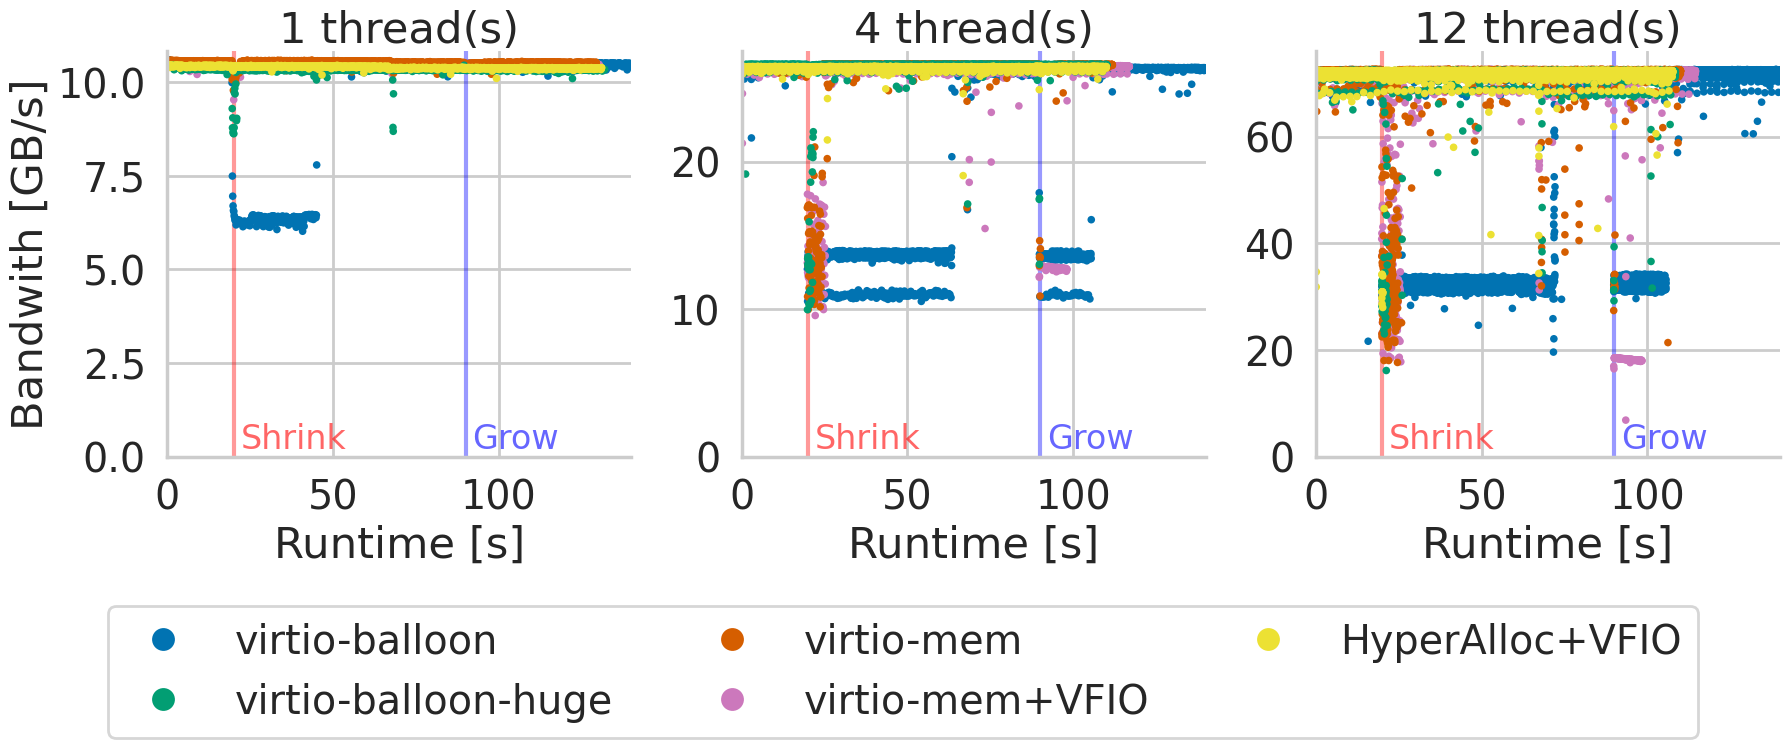

In [38]:
col_ord = [1, 4, 12]
order = ["virtio-balloon", "virtio-balloon-huge", "virtio-mem", "virtio-mem+VFIO", "HyperAlloc+VFIO"]

print(stream_meta)

p = sns.FacetGrid(stream, col="Cores", col_order=col_ord, sharey=False, height=6.5, aspect=1)
p.map_dataframe(sns.scatterplot, x="IterTime", y="Bandwidth", hue="Driver",
                hue_order=order, s=30.0, linewidth=0)
p.set_titles(col_template="{col_name} thread(s)")
p.add_legend(frameon=True, ncol=3, loc="upper center", bbox_to_anchor=(0.293, 0.04), markerscale=3)

p.set(ylabel="Bandwith [GB/s]")
p.set(xlabel="Runtime [s]")
p.set(ylim=(0, None))
p.set(xlim=(0, 140))
for ax in p.axes_dict.values():
    ax.axvline(stream_meta["args"]["post_delay"], color="red", alpha=0.4, zorder=0.9)
    ax.text(stream_meta["args"]["post_delay"] + 2, ax.viewLim.max[1] * 0.02,
            "Shrink", color="red", alpha=0.6, size=24)
    ax.axvline(stream_meta["args"]["deflate_delay"], color="blue", alpha=0.4, zorder=0.9)
    ax.text(stream_meta["args"]["deflate_delay"] + 2, ax.viewLim.max[1] * 0.02,
            "Grow", color="blue", alpha=0.6, size=24)

for key, ax in p.axes_dict.items():
    if key != 1: ax.set_ylabel("")
    for c in ax.get_children():
        if isinstance(c, matplotlib.collections.PathCollection):
            c.set_rasterized(True)
p.savefig("stream/stream.pdf", bbox_inches="tight", dpi=100)
p.savefig("stream/stream.svg", bbox_inches="tight", dpi=100)

In [21]:
percentile = stream[["Cores", "Driver", "Bandwidth"]][(stream["Cores"] == 1) | (stream["Cores"] == 4) | (stream["Cores"] == 12)].groupby(["Cores", "Driver"]).quantile(0.01)

dref_dataframe("stream_percentile", Path("stream"), ["Cores", "Driver"], percentile)
percentile

Bandwidth
Cores Driver                        
1     Baseline             10.302149
      HyperAlloc           10.317228
      HyperAlloc+VFIO      10.326146
      virtio-balloon        6.214011
      virtio-balloon-huge  10.087149
      virtio-mem           10.230609
      virtio-mem+VFIO      10.253598
4     Baseline             26.043777
      HyperAlloc           26.296870
      HyperAlloc+VFIO      26.081241
      virtio-balloon       10.902313
      virtio-balloon-huge  25.503378
      virtio-mem           13.050839
      virtio-mem+VFIO      12.627977
12    Baseline             68.994041
      HyperAlloc           70.069292
      HyperAlloc+VFIO      70.286437
      virtio-balloon       30.925110
      virtio-balloon-huge  67.801951
      virtio-mem           31.897693
      virtio-mem+VFIO      18.368992

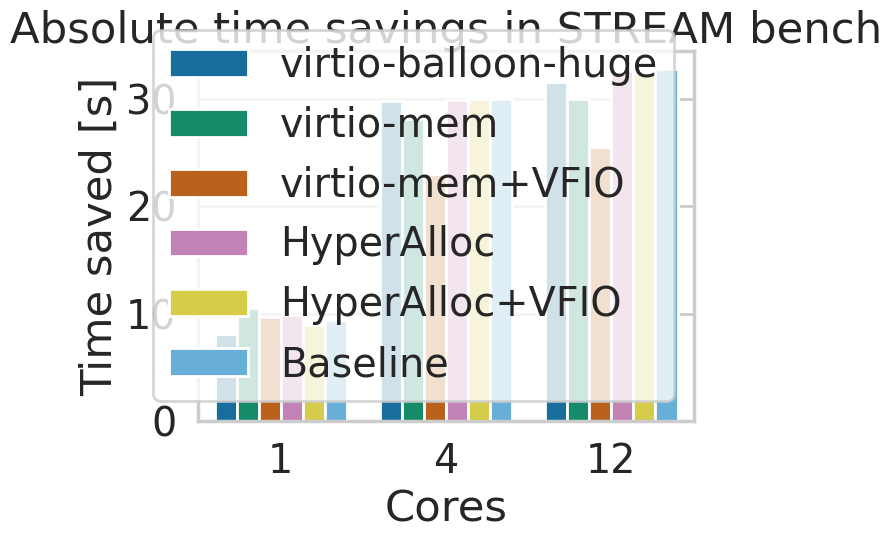

In [22]:
def calc_stream_speedz(cores: list[int]) -> pd.DataFrame:
    frames = []
    drivers = ["virtio-balloon-huge", "virtio-mem", "virtio-mem+VFIO", "HyperAlloc", "HyperAlloc+VFIO", "Baseline"]
    for c in cores:
        core_data = stream.loc[stream["Cores"] == c]
        virtio_balloon = core_data.loc[core_data["Driver"] == "virtio-balloon"]
        long_time = virtio_balloon["IterTime"][len(virtio_balloon["IterTime"]) - 1]
        times = []
        for driver in drivers:
            driver_data = core_data.loc[core_data["Driver"] == driver]
            times.append(long_time - driver_data["IterTime"][len(long_time - driver_data["IterTime"])-1])

        frames.append(pd.DataFrame({"Faster": times, "Driver": drivers}).assign(Cores=c))

    return pd.concat(frames)


stream_speedz = calc_stream_speedz([1, 4,12])
dref_dataframe("stream-speed", Path("stream"), ["Cores", "Driver"], stream_speedz)

plot = sns.barplot(data=stream_speedz, x="Cores", y="Faster", hue="Driver")
plot.set_ylabel("Time saved [s]")
plot.set_xlabel("Cores")
plot.set_title(f"Absolute time savings in STREAM bench")
plot.get_legend().set_title("")
sns.move_legend(plot, "lower right")

ValueError: 'yerr' (shape: (21,)) must be a scalar or a 1D or (2, n) array-like whose shape matches 'y' (shape: (28,))

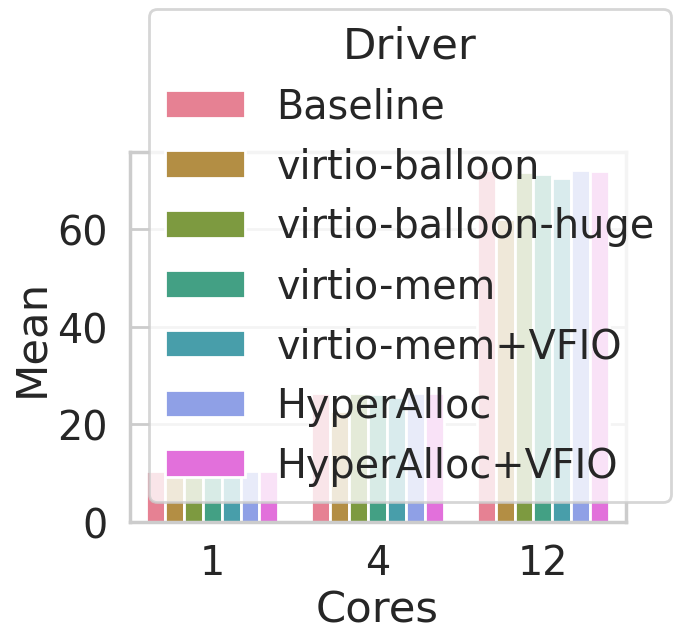

In [23]:
stream_stats = calc_stats(stream, [1, 4, 12], "Bandwidth")
dref_dataframe_multi("stream-stats", Path("stream"), ["Cores", "Driver"], ["Mean", "Std"], stream_stats)
plot = sns.barplot(data=stream_stats, x="Cores", y="Mean", hue="Driver")
x_coords = [p.get_x() + 0.5 * p.get_width() for p in plot.patches]
y_coords = [p.get_height() for p in plot.patches]
plot.errorbar(x=x_coords, y=y_coords, yerr=stream_stats["Std"], fmt="none", c="k")
plot.set_ylabel("Mean [GB/s]")
plot.set_xlabel("Cores")
plot.set_title(f"Mean and standard deviation for STREAM runs")
plot.get_legend().set_title("")
sns.move_legend(plot, "upper left")

In [31]:
def sum_ftqs_batched(path: Path, cores: int, driver: str, samples: int) -> pd.DataFrame:
    folder = DRIVER_MAP[driver]
    p = path / f"{folder}-ftq" / str(cores)
    out = pd.DataFrame()
    counts = list(map(lambda s: int(s), (p / "counts.dat").read_text().splitlines()))
    times = list(map(lambda s: int(s), (p / "times.dat").read_text().splitlines()))
    for i in range(0, cores):
        data = pd.DataFrame()
        data["Times"] = times[(samples*i):(samples*(i+1))]
        data["Counts"] = counts[(samples*i):(samples*(i+1))]
        if i == 0:
            out = data
        else:
            out["Counts"] += data["Counts"]
    start_cycle = out["Times"][0]
    out["Times"] -= start_cycle
    return out.tail(-1).assign(Cores=cores, Driver=driver)

def load_ftqs(p: Path, cores: list[int]) -> tuple[pd.DataFrame, dict[str, any]]:
    meta = json.load((p / f"{DRIVER_MAP["Baseline"]}-ftq" / "meta.json").open())
    frames = []
    for c in cores:
        for d in ["Baseline", "virtio-balloon", "virtio-mem+VFIO", "virtio-mem", "virtio-balloon-huge", "HyperAlloc", "HyperAlloc+VFIO"]:
            frames.append(sum_ftqs_batched(p, c, d, 1096))

    return pd.concat(frames), meta

ftq, ftq_meta = load_ftqs(Path("stream/latest"), [1, 4, 12])
dref_dataframe("ftq", Path("stream"), ["Driver", "Cores", "Times"], ftq)

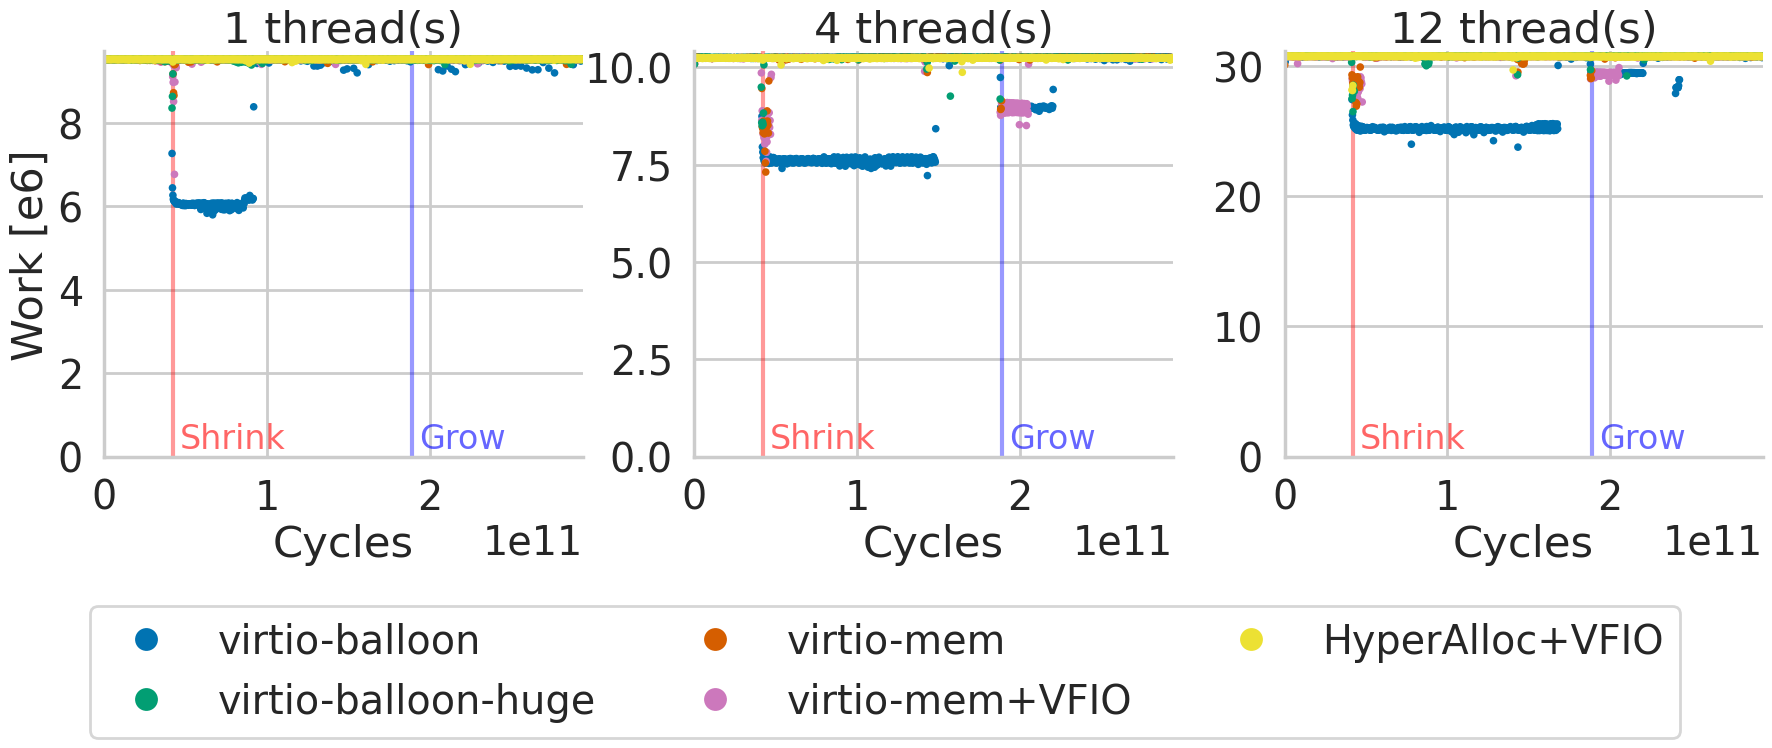

In [37]:
col_ord = [1, 4, 12]
order = ["virtio-balloon", "virtio-balloon-huge", "virtio-mem", "virtio-mem+VFIO", "HyperAlloc+VFIO"]

data = ftq.copy()
data["Counts"] /= 1e6
p = sns.FacetGrid(data, col="Cores", col_order=col_ord, sharey=False, height=6.5, aspect=1)
p.map_dataframe(sns.scatterplot, x="Times", y="Counts", hue="Driver",
                hue_order=order, s=30.0, linewidth=0)
p.set_titles(col_template="{col_name} thread(s)")
p.add_legend(frameon=True, ncol=3, loc="upper center", bbox_to_anchor=(0.293, 0.04), markerscale=3)
p.set(ylabel="Work [e6]")
p.set(xlabel="Cycles")
p.set(ylim=(0, None))
p.set(xlim=(0, ftq["Times"].max()))
for ax in p.axes_dict.values():
    cpu_freq = 2.1e9
    post_delay = ftq_meta["args"]["post_delay"] * cpu_freq
    ax.axvline(post_delay, color="red", alpha=0.4, zorder=0.9)
    ax.text(post_delay + 2 * cpu_freq, ax.viewLim.max[1] * 0.02,
            "Shrink", color="red", alpha=0.6, size=24)
    inflate_delay = ftq_meta["args"]["deflate_delay"] * cpu_freq
    ax.axvline(inflate_delay, color="blue", alpha=0.4, zorder=0.9)
    ax.text(inflate_delay + 2 * cpu_freq, ax.viewLim.max[1] * 0.02,
            "Grow", color="blue", alpha=0.6, size=24)

for key, ax in p.axes_dict.items():
    if key != 1: ax.set_ylabel("")
    for c in ax.get_children():
        if isinstance(c, matplotlib.collections.PathCollection):
            c.set_rasterized(True)
p.savefig("stream/ftq.pdf", bbox_inches="tight", dpi=100)
p.savefig("stream/ftq.svg", bbox_inches="tight", dpi=100)

In [27]:
percentile = ftq[["Cores", "Driver", "Counts"]][(ftq["Cores"] == 1) | (ftq["Cores"] == 4) | (ftq["Cores"] == 12)].groupby(["Cores", "Driver"]).quantile(0.01)

dref_dataframe("ftq_percentile", Path("stream"), ["Cores", "Driver"], percentile)
percentile

Counts
Cores Driver                          
1     Baseline              9448837.62
      HyperAlloc            9498493.86
      HyperAlloc+VFIO       9501345.02
      virtio-balloon        5928255.04
      virtio-balloon-huge   9456490.42
      virtio-mem            9455050.92
      virtio-mem+VFIO       9416442.98
4     Baseline             10215082.78
      HyperAlloc           10218937.62
      HyperAlloc+VFIO      10212312.90
      virtio-balloon        7475934.86
      virtio-balloon-huge  10129648.50
      virtio-mem            8574017.12
      virtio-mem+VFIO       8401878.24
12    Baseline             30627562.40
      HyperAlloc           30686425.36
      HyperAlloc+VFIO      30679454.18
      virtio-balloon       24942490.36
      virtio-balloon-huge  30148171.80
      virtio-mem           28734129.34
      virtio-mem+VFIO      28340112.94

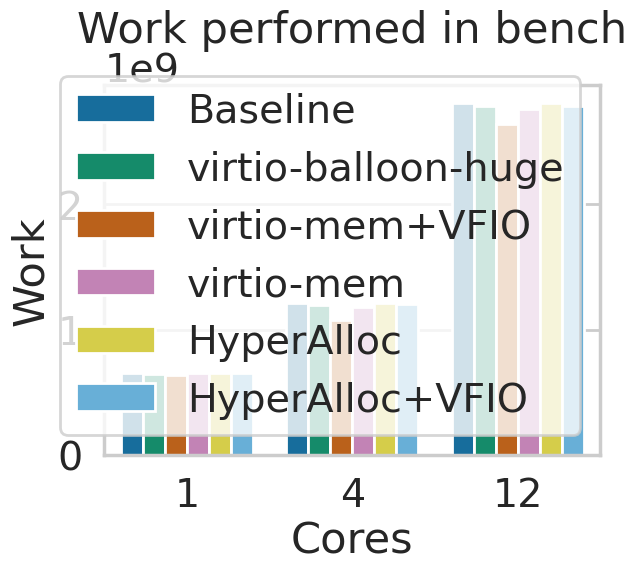

In [28]:
def calc_ftq_speedz(cores: list[int]) -> pd.DataFrame:
    frames = []
    drivers = ["Baseline", "virtio-balloon-huge", "virtio-mem+VFIO", "virtio-mem", "HyperAlloc", "HyperAlloc+VFIO"]
    for c in cores:
        core_data = ftq.loc[ftq["Cores"] == c]
        base = core_data.loc[core_data["Driver"] == "virtio-balloon"]["Counts"].sum()
        work = []
        for driver in drivers:
            driver_data = core_data.loc[core_data["Driver"] == driver]
            work.append(driver_data["Counts"].sum() - base)

        frames.append(pd.DataFrame({"Work": work, "Driver": drivers}).assign(Cores=c))

    return pd.concat(frames)


ftq_speedz = calc_ftq_speedz([1, 4, 12])
dref_dataframe("ftq-speed", Path("stream"), ["Cores", "Driver"], ftq_speedz)

plot = sns.barplot(data=ftq_speedz, x="Cores", y="Work", hue="Driver")
plot.set_ylabel("Work")
plot.set_xlabel("Cores")
plot.set_title(f"Work performed in bench")
plot.get_legend().set_title("")
sns.move_legend(plot, "lower right")

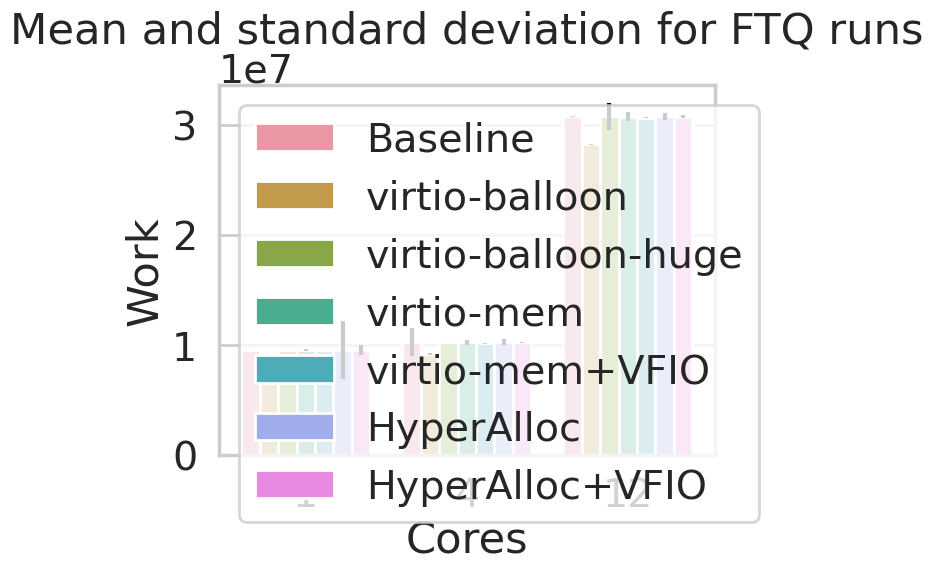

In [32]:
ftq_stats = calc_stats(ftq, [1, 4, 12], "Counts")
dref_dataframe_multi("ftq-stats", Path("stream"), ["Cores", "Driver"], ["Mean", "Std"], ftq_stats)
plot = sns.barplot(data=ftq_stats, x="Cores", y="Mean", hue="Driver")
x_coords = [p.get_x() + 0.5 * p.get_width() for p in plot.patches]
y_coords = [p.get_height() for p in plot.patches]
plot.errorbar(x=x_coords, y=y_coords, yerr=ftq_stats["Std"], fmt="none", c="k")
plot.set_ylabel("Work")
plot.set_xlabel("Cores")
plot.set_title(f"Mean and standard deviation for FTQ runs")
plot.get_legend().set_title("")
sns.move_legend(plot, "upper left")